# Microscope Development for Phase I:
- Multi-dataset training and testing
- Initial attempts at power assessment (marginal benefit from additional data) - within dataset

Eran Kotler \
python 3 \
2023-10-16


In [1]:
import os
import sys
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from multiprocessing import Pool
import warnings
import pickle
import microscope as mc
import data_organizer as do
from model_performance_utils import *
# from sklearn.metrics import classification_report
# from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, balanced_accuracy_score
# from sklearn.model_selection import KFold, LeaveOneOut, train_test_split
# import timeit

sns.set_style("white")
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
base_d = "/Users/erankotler/dinamo"
data_d = os.path.join(base_d, "data/gse_data_20231002")

results_d = os.path.join(base_d, "resutls")
models_d = os.path.join(base_d, "models")


In [3]:
[d for d in os.listdir(data_d) if d.startswith("GSE")]

['GSE145361',
 'GSE111223',
 'GSE190348',
 'GSE42861',
 'GSE111942',
 'GSE87095',
 'GSE147221',
 'GSE175364',
 'GSE111629',
 'GSE121192']

In [5]:
gse_acc = "GSE111223"
gse_d = os.path.join(data_d, gse_acc)
data = do.Dataset(gse_d=gse_d)
# data.load_data() 
data.load_data(max_CpGs=500, max_samps=20) # For debugging
data.organize_data()

# Examine original label names
print("Original labels:", data.orig_label_names)
print("Number of samples:", data.df.shape[0])

cv_res = mc.cv_train_test(
    data, 
    CV = 10, # "LOO" # 10 #"LOO"
    penalty = 'l1', 
    internalCV_folds = 5,
    nan_policy="impute_by_median",
    feat_selection='wilcox',
    feat_selection_pval_thresh=0.05)

Target label counts (0/1): 10 / 10
Original labels: ['case' 'control']
Number of samples: 20
Starting cross validation
Starting fold 0 - Train-test splitting
CV fold 0 Train size: 18, test size: 2 (fract positives in train: 0.444)
Imputing missing values, elapsed time: 0.0 sec
Starting feature selection, elapsed time: 0.0 sec
Selecting features using wilcoxon
Retained 8 features
Feature selection complete, ready for training, elapsed time: 0.0 sec
Fold complete, fold time: 1.2 sec
Starting fold 1 - Train-test splitting
CV fold 1 Train size: 18, test size: 2 (fract positives in train: 0.556)
Imputing missing values, elapsed time: 0.0 sec
Starting feature selection, elapsed time: 0.0 sec
Selecting features using wilcoxon
Retained 23 features
Feature selection complete, ready for training, elapsed time: 0.0 sec
Fold complete, fold time: 0.5 sec
Starting fold 2 - Train-test splitting
CV fold 2 Train size: 18, test size: 2 (fract positives in train: 0.500)
Imputing missing values, elapsed t

### Load multiple RA datasets
    

In [5]:
# gse_acc1,gse_acc2  = ["GSE42861","GSE111942"]#"GSE111223"
def get_data(gse_d):
    data = do.Dataset(gse_d=gse_d)
    data.load_data() 
    # data.load_data(max_CpGs=5000, max_samps=100) # For debugging
    data.organize_data()
    return(data)

In [7]:
RA_datasets = ["GSE42861","GSE111942","GSE121192","GSE87095"]
    
datas = {}
for i, gse_acc in enumerate(RA_datasets):
    print("Getting data for", gse_acc)
    gse_d = os.path.join(data_d, gse_acc)
    datas[i] = get_data(gse_d)

Getting data for GSE42861
Target label counts (0/1): 335 / 354
Getting data for GSE111942
Target label counts (0/1): 18 / 25
Getting data for GSE121192
Target label counts (0/1): 16 / 30
Getting data for GSE87095
Target label counts (0/1): 73 / 49


In [9]:
# Merging two datasets
dataset1 = datas[1]
dataset2 = datas[2]

merged = do.merge_datasets(dataset1, dataset2, feature_merge="inner")

Target label counts (0/1): 34 / 55


#### CV perfromance wihtin merged dataset (2 RA datasets together)

In [243]:
cv_res = mc.cv_train_test(
    merged, 
    CV = 10, # "LOO" # 10 #"LOO"
    penalty = 'l1', 
    internalCV_folds = 5,
    nan_policy="impute_by_median",
    feat_selection='wilcox',
    feat_selection_pval_thresh=0.05)

Starting cross validation
Starting fold 0 - Train-test splitting
CV fold 0 Train size: 80, test size: 9 (fract positives in train: 0.613)
Imputing missing values, elapsed time: 0.2 sec
Starting feature selection, elapsed time: 1.2 sec
Selecting features using wilcoxon
Retained 44480 features
Feature selection complete, ready for training, elapsed time: 15.6 sec
Fold complete, fold time: 19.1 sec
Starting fold 1 - Train-test splitting
CV fold 1 Train size: 80, test size: 9 (fract positives in train: 0.625)
Imputing missing values, elapsed time: 0.3 sec
Starting feature selection, elapsed time: 1.4 sec
Selecting features using wilcoxon
Retained 36359 features
Feature selection complete, ready for training, elapsed time: 15.8 sec
Fold complete, fold time: 18.2 sec
Starting fold 2 - Train-test splitting
CV fold 2 Train size: 80, test size: 9 (fract positives in train: 0.613)
Imputing missing values, elapsed time: 0.1 sec
Starting feature selection, elapsed time: 1.2 sec
Selecting features 

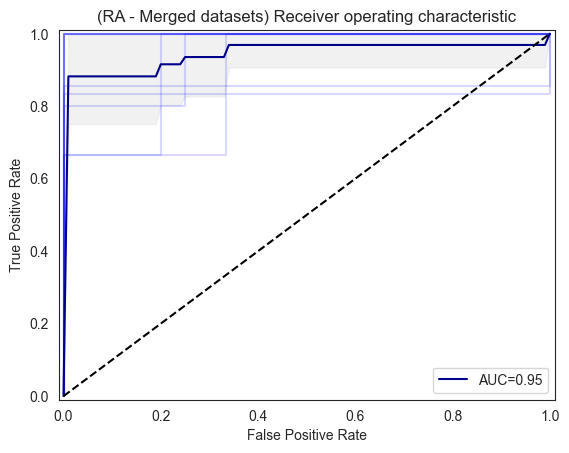

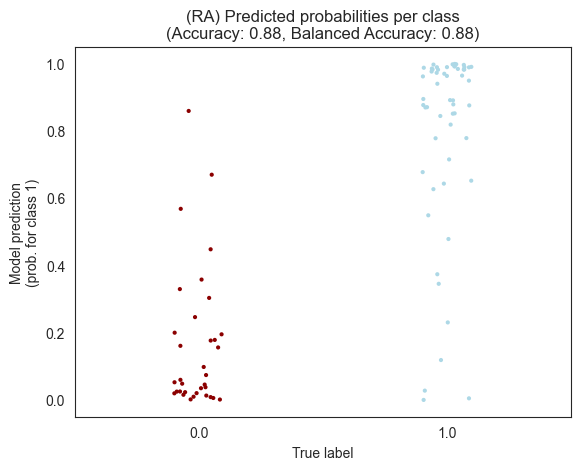

              precision    recall  f1-score   support

         0.0       0.79      0.91      0.85        34
         1.0       0.94      0.85      0.90        55

    accuracy                           0.88        89
   macro avg       0.87      0.88      0.87        89
weighted avg       0.88      0.88      0.88        89



In [244]:
mc.plot_cv_roc(cv_res, title_pfx="(RA - Merged datasets)")#, out_f=os.path.join(figs_d, cv_res["file_pfx"]+"_ROC.pdf"))
mc.plot_pred_prob_by_labels(cv_res, title_pfx="(RA)")#, out_f=os.path.join(figs_d, cv_res["file_pfx"]+"_class_pred_probs.pdf"))
mc.print_report(cv_res, THRESH=0.5)

#### Inter-dataset prediction: Train on merged (2 datasets), predict on third dataset

In [252]:
%%time
train_dataset = merged # datas[2]
res1 = mc.train_on_entire_dataset(
    train_dataset,
    penalty = 'l2',
    scale_data = False,#True, #
    internalCV_folds = 5,
    nan_policy="impute_by_median",
    feat_selection="wilcox",
    feat_selection_pval_thresh=0.05,
    out_f=None)

Removing/imputing NaN feature values
Selecting features using wilcoxon
Retained 49722 features
Training model
Run time: 83.9 sec
CPU times: user 5min 13s, sys: 3min 57s, total: 9min 10s
Wall time: 1min 23s


In [253]:
res1["trained_model"].C_

array([2.7825594])

In [254]:
%%time
pred_data = datas[0]

y_pred, y_pred_prob = mc.predict_with_trained_model(
    pred_data=pred_data,
    model=res1["trained_model"], 
    model_features=res1["features_used"], 
    scaler=res1["scaler"], 
    imp_vals=res1["imputation_vals"]
)

y_true = pred_data.y

49722 features used for prediction
Imputing NaN feature values
CPU times: user 357 ms, sys: 669 ms, total: 1.03 s
Wall time: 187 ms


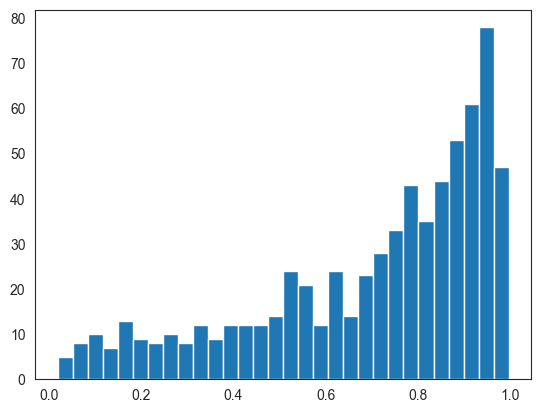

In [255]:
plt.hist(y_pred_prob, bins=30);#, range = [1-0.00001, 1]);

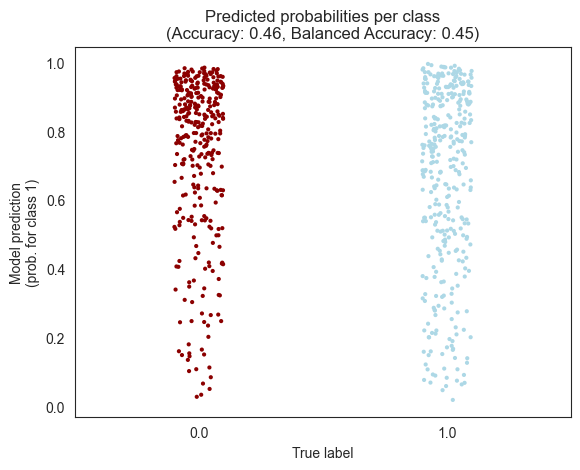

In [256]:
sns.stripplot(x=y_true, y=y_pred_prob, size=3, palette=["darkred","lightblue"])
plt.xlabel("True label")
plt.ylabel("Model prediction\n(prob. for class 1)")

score = accuracy_score(y_true, y_pred)
bal_score = balanced_accuracy_score(y_true, y_pred) # Defined as averaged recall for each class

plt.title('Predicted probabilities per class\n(Accuracy: %.2f, Balanced Accuracy: %.2f)'%(score, bal_score))

# if out_f is not None:
#     plt.savefig(out_f)        
plt.show()

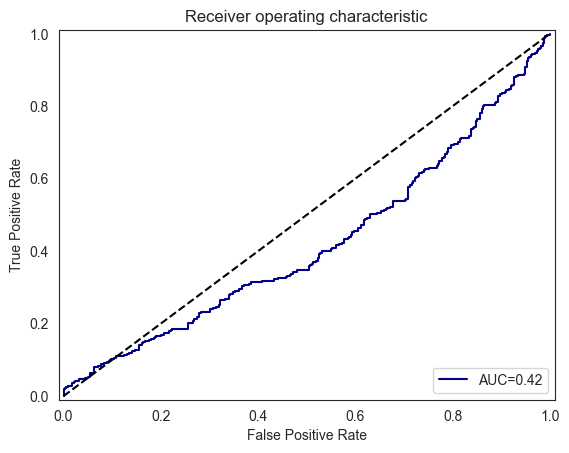

In [258]:
auc = roc_auc_score(y_true, y_pred_prob)
fpr, tpr, thresholds = roc_curve(y_true,  y_pred_prob)
plt.plot(fpr,tpr, c='darkblue', label="AUC=%0.2f"%auc)
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
# if out_f is not None:
#     plt.savefig(out_f)
plt.show()

##### => Complete failure to generalize across datasets

### Power estimation - within a single dataset

In [51]:
dataset = datas[0]

In [58]:
dataset.gse_d

'/Users/erankotler/dinamo/data/gse_data_20231002/GSE42861'

In [52]:
dataset.df.shape

(689, 486427)

In [53]:
# fracts = [0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 1]

fracts = [0.1, 0.3, 0.5, 0.7, 0.9, 1]
train_dfs, train_ys, df_test, y_test = mc.create_downsampled_train_sets(dataset, rel_train_fracts = fracts, test_frac=0.3)

In [54]:
auc_scores, acc_scores, train_sizes = {}, {}, {}

for frac in list(train_dfs.keys()):
    print("==== Starting Evaluating train set fraction of %.3f ===="%frac)
    auc_scores[frac], acc_scores[frac], train_sizes[frac] = mc.train_score(
        train_dfs[frac], df_test, train_ys[frac], y_test,
        penalty = 'l2', 
        internalCV_folds = 5,
        feat_selection="wilcox",
        feat_selection_pval_thresh=0.1,
        nan_policy="impute_by_median",
        min_train_size=20)
    

==== Starting Evaluating train set fraction of 0.100 ====
Evaluating model trained on 48 samples (test set size: 207 samples
Imputing missing values, elapsed time: 0.2 sec
Starting feature selection, elapsed time: 1.0 sec
Selecting features using wilcoxon
Retained 88088 features
Feature selection complete, starting training, elapsed time: 14.7 sec
==== Starting Evaluating train set fraction of 0.300 ====
Evaluating model trained on 144 samples (test set size: 207 samples
Imputing missing values, elapsed time: 0.3 sec
Starting feature selection, elapsed time: 2.8 sec
Selecting features using wilcoxon
Retained 157602 features
Feature selection complete, starting training, elapsed time: 25.7 sec
==== Starting Evaluating train set fraction of 0.500 ====
Evaluating model trained on 241 samples (test set size: 207 samples
Imputing missing values, elapsed time: 0.3 sec
Starting feature selection, elapsed time: 4.9 sec
Selecting features using wilcoxon
Retained 182094 features
Feature selectio

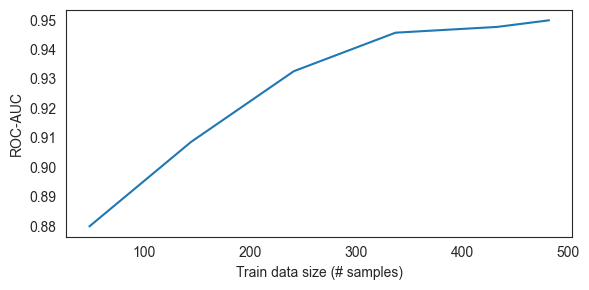

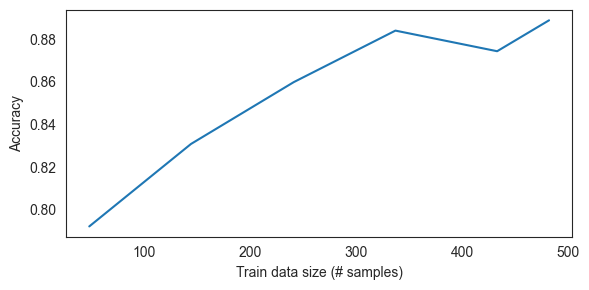

In [56]:
plot_performance_vs_data_size(train_sizes, auc_scores, score_name="ROC-AUC")
plot_performance_vs_data_size(train_sizes, acc_scores, score_name="Accuracy")

#### Same with a large PD dataset:

In [59]:
gse_d = os.path.join(data_d, "GSE145361") # large PD dataset
pd_dataset = get_data(gse_d)


Target label counts (0/1): 930 / 959


In [60]:
fracts = [0.1, 0.3, 0.5, 0.7, 0.9, 1]
train_dfs, train_ys, df_test, y_test = mc.create_downsampled_train_sets(pd_dataset, 
                                                                        rel_train_fracts = fracts,
                                                                        test_frac=0.3)

In [61]:
auc_scores, acc_scores, train_sizes = {}, {}, {}

for frac in list(train_dfs.keys()):
    print("==== Starting Evaluating train set fraction of %.3f ===="%frac)
    auc_scores[frac], acc_scores[frac], train_sizes[frac] = mc.train_score(
        train_dfs[frac], df_test, train_ys[frac], y_test,
        penalty = 'l2', 
        internalCV_folds = 5,
        feat_selection="wilcox",
        feat_selection_pval_thresh=0.1,
        nan_policy="impute_by_median",
        min_train_size=20)
    

==== Starting Evaluating train set fraction of 0.100 ====
Evaluating model trained on 132 samples (test set size: 567 samples
Imputing missing values, elapsed time: 0.9 sec
Starting feature selection, elapsed time: 3.7 sec
Selecting features using wilcoxon
Retained 99947 features
Feature selection complete, starting training, elapsed time: 33.6 sec
==== Starting Evaluating train set fraction of 0.300 ====
Evaluating model trained on 396 samples (test set size: 567 samples
Imputing missing values, elapsed time: 1.0 sec
Starting feature selection, elapsed time: 11.5 sec
Selecting features using wilcoxon
Retained 219115 features
Feature selection complete, starting training, elapsed time: 81.1 sec
==== Starting Evaluating train set fraction of 0.500 ====
Evaluating model trained on 661 samples (test set size: 567 samples
Imputing missing values, elapsed time: 1.5 sec
Starting feature selection, elapsed time: 9.3 sec
Selecting features using wilcoxon
Retained 279608 features
Feature select

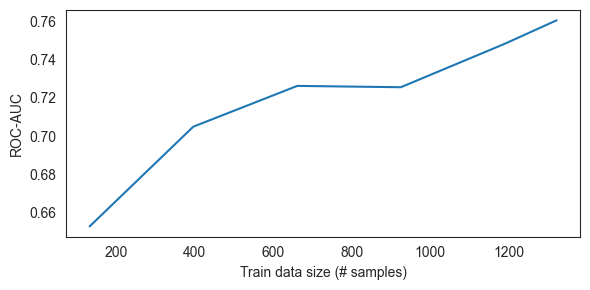

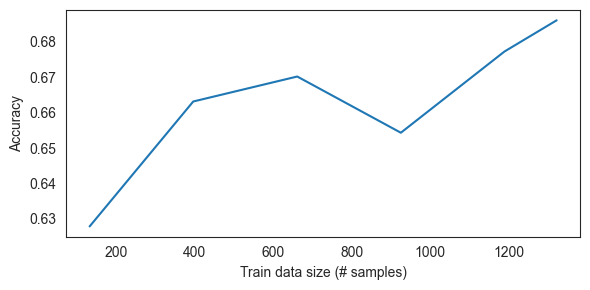

In [62]:
plot_performance_vs_data_size(train_sizes, auc_scores, score_name="ROC-AUC")
plot_performance_vs_data_size(train_sizes, acc_scores, score_name="Accuracy")

# -- END OF NOTEBOOK ---

In [4]:
# gse_acc = "GSE111223" # PD ~260 samps
# gse_acc = "GSE111629" # PD ~570 samps
# gse_acc = "GSE145361" # PD, ~1800 samps

PD_datasets = ["GSE145361","GSE111629", "GSE190348", "GSE111223"]
RA_datasets = ["GSE42861","GSE111942","GSE121192","GSE87095"] # "GSE175364" is a 78-patient dataset for prediction of  undifferentiated arthritis (UA)=>RA progression with only 6 controls